### This notebook should be used for testing new datasets and models when saving their activations at inference time.

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import hydra
from hydra import compose, initialize
from hydra.utils import instantiate
import pytorch_lightning as pl
import torch
import pyrootutils

from utils import instantiate_modules

In [7]:
def setup(probe='default', dataset='default'):
    '''
    Annoying but necessary function to setup the hydra environment within a jupyter notebook.
    '''
    pyrootutils.setup_root('.', dotenv=True, pythonpath=True)
    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(config_path='config')
    cfg = compose(config_name='probing', overrides=[f'probe={probe}', f'dataset={dataset}'])
    return cfg

In [8]:
# Basic setup for probing the model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
cfg = setup(probe='pooled_probe', dataset='counting',)

# Set seeds
pl.seed_everything(cfg.seed)

# Load dataset first to determine dimensions
dataset = hydra.utils.instantiate(cfg.dataset)
train_loader, test_loader, val_loader = dataset.load()

# Get dimensions from the dataset
input_dim = train_loader.dataset.features.shape[-1]
output_dim = train_loader.dataset.label_dim

# Initialize model with dimensions from dataset
model = hydra.utils.instantiate(
        cfg.probe,
        input_dim=input_dim,
        hidden_dim=input_dim,  # Hidden dim for pooled probe is same as input
        output_dim=output_dim
    )

[rank: 0] Seed set to 1248


Using device: cuda


In [9]:
# Initialize callbacks and logger
callbacks = instantiate_modules(cfg.get('callbacks'))
loggers = instantiate_modules(cfg.get('logger'))

# Initialize trainer
trainer = hydra.utils.instantiate(
    cfg.trainer,
    callbacks=callbacks,
    logger=loggers
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [10]:
# Train model
trainer.fit(
    model=model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type  | Params | Mode 
---------------------------------------
0 | net  | Probe | 12.9 M | train
---------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.581    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0:   0%|                                                                                       | 0/3 [00:00<?, ?it/s]

AttributeError: module 'torch.nn.functional' has no attribute 'sofmax'

In [2]:
import ast
from glob import glob
import os
import warnings
import itertools
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import pearsonr, ttest_ind
from scipy.special import xlogy

import sys
sys.path.append('../')
from utils import *

warnings.filterwarnings('ignore')

In [3]:
def find_neighbor_inds(matrix, i, j):
    col_inds = np.where(matrix[i, :])[0]
    row_inds = np.where(matrix[:, j])[0]
    col_neighbor_inds = np.stack((np.repeat(i, len(col_inds)), col_inds)).T
    row_neighbor_inds = np.stack((row_inds, np.repeat(j, len(row_inds)))).T 
    return np.vstack([row_neighbor_inds, col_neighbor_inds])

def count_triplets(x, y):
    '''Count the number of opportunities the model has to make a binding error.
    '''
    matrix = np.einsum('tx,ty->txy', x, y).sum(0)  # [x_classes, y_classes]
    assert x.ndim == y.ndim == 2
    assert x.shape[0] == y.shape[0]
    rows, cols = matrix.shape
    triplet_count = 0

    # Iterate through each element in the matrix
    for i in range(rows):
        for j in range(cols):
            if matrix[i, j] == 0:
                continue
            
            # Find the neighbors to the non-zero elements
            neighbor_inds = find_neighbor_inds(matrix, i, j)

            # Check the neighbors for non-zero neighbors.
            for neighbor in neighbor_inds:
                if not np.allclose(neighbor, [i,j]):
                    if neighbor[0] != i:
                        row = matrix[neighbor[0], :] - matrix[i, :]
                        row[row < 0] = 0
                        mask = np.ones(len(row), dtype=bool)
                        mask[j] = False # exclude the neighbor
                        triplet_count += row[mask].sum()
                    elif neighbor[1] != j: 
                        col = matrix[:, neighbor[1]] - matrix[:, j]
                        col[col < 0] = 0
                        mask = np.ones(len(col), dtype=bool)
                        mask[i] = False
                        triplet_count += col[mask].sum()
                    else:
                        print('got original')
    return triplet_count

def bin_metric(df, metric, n_bins=5):
    bins = pd.cut(df[metric], bins=n_bins)
    df[f'binned_{metric}'] = bins.apply(lambda x: float(x.left)).astype(float)
    return df

def preprocess_df(df, condition='2D'):
    df = df[~df.response.isna()]
    df['answer'] = df.response.apply(lambda x: x.replace('`', '').replace('json', '').strip())
    df['answer'] = df.answer.str.extract(r'(\[\s*\{.*?\}\s*\])', flags=re.DOTALL)
    df['parsed_response'] = np.nan
    df['parsed_response'] = df.parsed_response.astype(object)
    df = df[df.answer != -1]
    # remove comments from the response string
    for i, row in df.iterrows():
        try:
            df.loc[i,'answer'] = row.answer.replace('\n', '')
            df.loc[i,'answer'] = row.answer.replace(' ', '')
        except:
            df.loc[i,'answer'] = np.nan
    df = df[~df.answer.isna()]
    df['answer'] = df.answer.apply(lambda x: x.replace('\n', ''))
    df['answer'] = df.answer.apply(lambda x: x.replace(' ', ''))
    df['answer'] = df.answer.str.lower()
    df['features'] = df.features.apply(lambda x: x.replace(' ', ''))
    df['features'] = df.features.str.lower()
    df['features'] = df.features.apply(lambda x: eval(x))
    # convert responses/trial features to a list of dictionaries, where possible
    df['colors'] = df.features.apply(lambda x: [val['color'] for key, val in x.items()])
    df['shapes'] = df.features.apply(lambda x: [val['shape'] for key, val in x.items()])
    color_names = df.colors.explode().unique()
    shape_names = df.shapes.explode().unique()
    # Construct one-hot encodings for the colors and shapes
    df['color_vecs'] = df.features.apply(lambda x: np.array([color_names==val['color'] for _, val in x.items()]).astype(bool))
    df['shape_vecs'] = df.features.apply(lambda x: np.array([shape_names==val['shape'] for _, val in x.items()]).astype(bool))
    for i, row in df.iterrows():
        try:
            df.at[i, 'parsed_response'] = eval(row.answer)
        except:
            df.at[i, 'parsed_response'] = np.nan
    # set rows with a degenerate response to nan
    df = df[~df.parsed_response.isna()]
    df['json_keys'] = df.parsed_response.apply(lambda x: [obj.keys() for obj in x])
    df['json_keys'] = df.json_keys.apply(lambda x: np.array(list(itertools.chain(*x))))
    df = df[df.apply(lambda x: (x.json_keys=='color').sum()==len(x.parsed_response) and (x.json_keys=='shape').sum()==len(x.parsed_response), axis=1)]
    df['model_colors'] = df.parsed_response.apply(lambda x: np.array([obj['color'] for obj in x]))
    df['model_shapes'] = df.parsed_response.apply(lambda x: np.array([obj['shape'] for obj in x]))
    df['model_color_vecs'] = df.parsed_response.apply(lambda x: np.array([color_names==obj['color'] for obj in x]).astype(bool))
    df['model_shape_vecs'] = df.parsed_response.apply(lambda x: np.array([shape_names==obj['shape'] for obj in x]).astype(bool))
    df['n_shapes'] = df.features.apply(lambda x: len(set(x)))
    df['n_colors'] = df.features.apply(lambda x: len(set(x)))
    df['n_features'] = df['n_shapes'] + df['n_colors']
    return df

def load_scene_description(model, n_bins=10):
    path = f'/scratch/gpfs/JDC/declan/probing/output/scene_description_OLD/{model}/model_responses.csv'
    df = pd.read_csv(path)
    df = preprocess_df(df)
    # Count the dependent measures for each trial
    df['triplet_count'] = df.apply(lambda x: count_triplets(x.color_vecs, x.shape_vecs), axis=1)
    # add some utility columns that will be useful for later analysis.
    df['feature_matrix'] = df.apply(lambda x: np.einsum('tx,ty->txy', x.color_vecs, x.shape_vecs).sum(0), axis=1)
    df['model_feature_matrix'] = df.apply(lambda x: np.einsum('tx,ty->txy', x.model_color_vecs, x.model_shape_vecs).sum(0), axis=1)
    df['nDiff'] = df.apply(lambda x: np.abs(x.feature_matrix-x.model_feature_matrix).sum(), axis=1)
    df['model'] = model
    return df

def plot_results(df, model, measure='swap_count', metric='swap_error', n_bins=5, n_trials_threshold=20):
    model_map = {'qwen': 'Qwen2-VL'}
    if model != 'all':
        model_df = df[df['model'] == model]
        title = model_map[model]
    else:
        model_df = df
        title = f'{condition} VLM Average'
    fig, ax = plt.subplots(figsize=(4, 6))
    cmin = model_df.n_objects.min()
    cmax = model_df.n_objects.max()
    cmap = plt.cm.get_cmap('rainbow')
    norm = plt.Normalize(cmin, cmax)
    for n_obj in sorted(model_df['n_objects'].unique()):
        obj_df = model_df[model_df['n_objects'] == n_obj]
        value_counts = obj_df['triplet_count'].value_counts()
        mask = obj_df['triplet_count'].isin(value_counts.index[value_counts >= n_trials_threshold])
        obj_df = obj_df[mask]
        obj_df = bin_metric(obj_df, metric, n_bins=n_bins)
        stats = pearsonr(obj_df[metric], obj_df[measure], alternative='greater')
        label = f'{n_obj}'
        print(f'{model} {n_obj} {measure} vs. {metric} r: {stats[0]:.2f}, p: {stats[1]:.2f}')
        sns.lineplot(obj_df, x=f'binned_{metric}', y=measure, label=label, ax=ax, errorbar='se', c=cmap(norm(n_obj)), marker='o')
    plt.legend(title='', loc='lower right', fontsize=16)
    plt.xlabel(metric, fontsize=17)
    plt.ylabel(measure, fontsize=17)
    plt.title(title, fontsize=18.5)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    sns.despine()
    plt.legend(title='nObjects', loc='lower right', fontsize=12, title_fontsize=14)
    return fig

def counting_error(truth, prediction):
    return np.abs(np.sum(truth) - np.sum(prediction))

def hallucination_error(truth, prediction):
    f1_mask = np.logical_not(np.any(truth > 0, axis=1))
    f2_mask = np.logical_not(np.any(truth > 0, axis=0))
    f1_hallucinations = prediction[f1_mask].sum()
    f2_hallucinations = prediction[:, f2_mask].sum()
    return f1_hallucinations + f2_hallucinations

def binding_error(truth, prediction):
    f1_mask = np.any(truth > 0, axis=1)
    f2_mask = np.any(truth > 0, axis=0)
    inds = np.ix_(f1_mask, f2_mask)
    return np.abs(truth[inds] - prediction[inds]).sum()

In [6]:
# load the data for each available model
models = ['qwen']
results = pd.concat([load_scene_description(model) for model in models])
results.loc[results['n_objects']==5, 'n_objects'] = 10
results.loc[results['n_objects']==6, 'n_objects'] = 11
results.loc[results['n_objects']==7, 'n_objects'] = 12

# Apply these functions to create new columns
results['counting_errors'] = results.apply(lambda row: counting_error(row['feature_matrix'], row['model_feature_matrix']), axis=1)
results['hallucination_errors'] = results.apply(lambda row: hallucination_error(row['feature_matrix'], row['model_feature_matrix']), axis=1)
results['binding_errors'] = results.apply(lambda row: binding_error(row['feature_matrix'], row['model_feature_matrix']), axis=1)
results.reset_index(drop=True, inplace=True)

qwen 10 binding_errors vs. triplet_count r: 0.15, p: 0.00
qwen 11 binding_errors vs. triplet_count r: 0.12, p: 0.00
qwen 12 binding_errors vs. triplet_count r: 0.09, p: 0.00


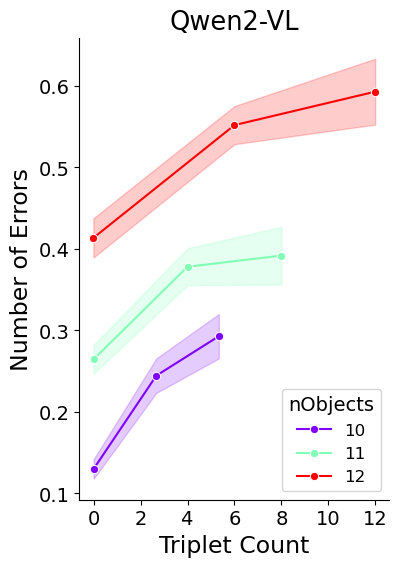

In [7]:
# Plot the results
fig = plot_results(results, 'qwen', metric='triplet_count', measure='binding_errors', n_bins=3)
plt.ylabel('Number of Errors')
plt.xlabel('Triplet Count')
plt.savefig(f'qwen_binding_errors.pdf', bbox_inches='tight')

In [5]:
test

NameError: name 'test' is not defined